# Getting Started with RasterFrames Notebook

## Setup Spark Environment

In [1]:
import pyrasterframes
import pyrasterframes.rf_ipython  # enables nicer visualizations of pandas DF
from pyrasterframes.rasterfunctions import (rf_local_add, rf_dimensions, rf_extent, rf_crs, 
                                            st_geometry, st_reproject, rf_tile)
import pyspark.sql.functions as F

In [2]:
spark = pyrasterframes.get_spark_session()

### Get a PySpark DataFrame from [open data](https://docs.opendata.aws/modis-pds/readme.html)

Read a single "granule" of MODIS surface reflectance data. 

In [3]:
uri = 'https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059' \
      '/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF'
df = spark.read.raster(uri)

In [4]:
df.printSchema()

root
 |-- proj_raster_path: string (nullable = false)
 |-- proj_raster: struct (nullable = true)
 |    |-- tile_context: struct (nullable = false)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)



Do some work with the raster data; add 3 element-wise to the pixel/cell values and show some rows of the DataFrame.

In [5]:
df.select(rf_local_add(df.proj_raster, F.lit(3))).show(5, False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rf_local_add(proj_raster, 3)                                                                                                                                                                                                                                                                            |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[[-7783653.637667, 993342.4642358534, -7665045.582235852, 1111950.519667], [+proj=sinu +lon_0=0.0 +x_

The extent struct tells us where in the [CRS](https://spatialreference.org/ref/sr-org/6842/) the tile data covers. The granule is split into arbitrary sized chunks. Each row is a different chunk. Let's see how many.

Side note: you can configure the default size of these chunks, which are called Tiles, by passing a tuple of desired columns and rows as: `raster(uri, tile_dimensions=(96, 96))`. The default is `(256, 256)`

In [6]:
df.count()

100

What area does the DataFrame cover?

coverage_area = df.groupby(df.proj_raster_path).agg(
    F.first(rf_crs(df.proj_raster).crsProj4).alias('crs'),
    F.min(rf_extent(df.proj_raster).xmin).alias('xmin'),
    F.min(rf_extent(df.proj_raster).ymin).alias('ymin'),
    F.min(rf_extent(df.proj_raster).xmax).alias('xmax'),
    F.min(rf_extent(df.proj_raster).ymax).alias('ymax'),
).withColumn('footprint_4326', st_geometry(F.struct('xmin', 'ymin', 'xmax', 'ymax')))
coverage_area = cov_area()
coverage_area

In [7]:
crs = df.agg(F.first(rf_crs(df.proj_raster)).crsProj4.alias('crs')).first()['crs']
print(crs)
coverage_area = df.select(
                           df.proj_raster_path,
                           st_reproject(st_geometry(rf_extent(df.proj_raster)), crs, 'EPSG:4326').alias('footprint')
                         )
coverage_area.show(10, False)

+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m 
+--------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|proj_raster_path                                                                                              |footprint                                                                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

So where in the world is that? We'll generate a little visualization on http://geojson.io.

In [8]:
import geopandas
import geojsonio

geojsonio.display(
    geopandas.GeoDataFrame(
        coverage_area.select('footprint').toPandas(), geometry='footprint', crs='EPSG:4326').to_json()
)

'http://geojson.io/#data=data:application/json,%7B%22type%22%3A%20%22FeatureCollection%22%2C%20%22features%22%3A%20%5B%7B%22id%22%3A%20%220%22%2C%20%22type%22%3A%20%22Feature%22%2C%20%22properties%22%3A%20%7B%7D%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B-70.85954815687087%2C%208.933333332533772%5D%2C%20%5B-71.07986282542622%2C%209.999999999104968%5D%2C%20%5B-69.99674110618135%2C%209.999999999104968%5D%2C%20%5B-69.7797836135278%2C%208.933333332533772%5D%2C%20%5B-70.85954815687087%2C%208.933333332533772%5D%5D%5D%7D%7D%2C%20%7B%22id%22%3A%20%221%22%2C%20%22type%22%3A%20%22Feature%22%2C%20%22properties%22%3A%20%7B%7D%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B-69.77978361352781%2C%208.933333332533772%5D%2C%20%5B-69.99674110618135%2C%209.999999999104968%5D%2C%20%5B-68.91361938693649%2C%209.999999999104968%5D%2C%20%5B-68.70001907018472%2C%208.933333332533772%5D%2C%20%5B-69.77978361352781%

Look at a sample of the data.

,proj_raster_path,extent,tile
0,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7427829.47137356, 993342.4642358534, -7309221.415942413, 1111950.519667)",
1,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7309221.415942414, 993342.4642358534, -7190613.360511266, 1111950.519667)",
2,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-6953397.249648973, 756126.3533735601, -6834789.194217825, 874734.4088047068)",
3,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7783653.637667, 281694.1316489733, -7665045.582235852, 400302.18708011997)",
4,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7783653.637667, 163086.07621782675, -7665045.582235852, 281694.1316489733)",
5,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-6834789.194217826, 163086.07621782675, -6716181.138786679, 281694.1316489733)",

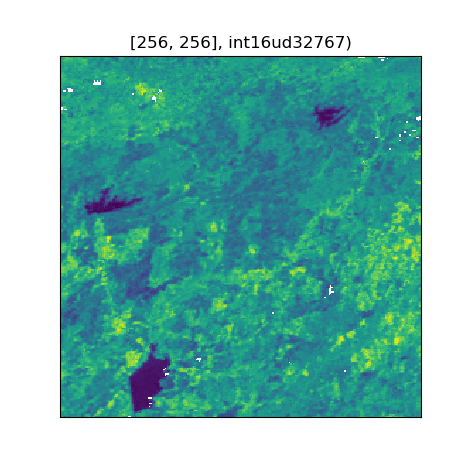
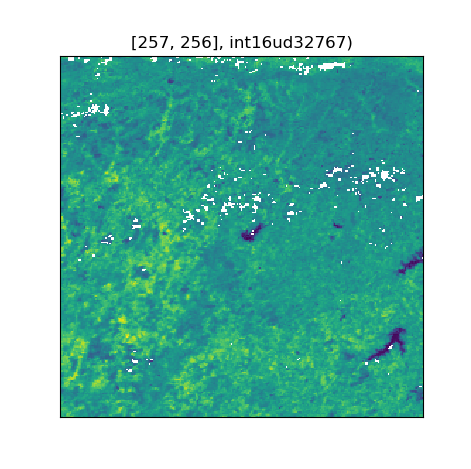
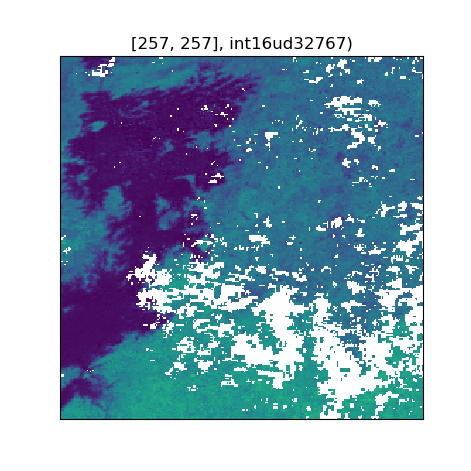
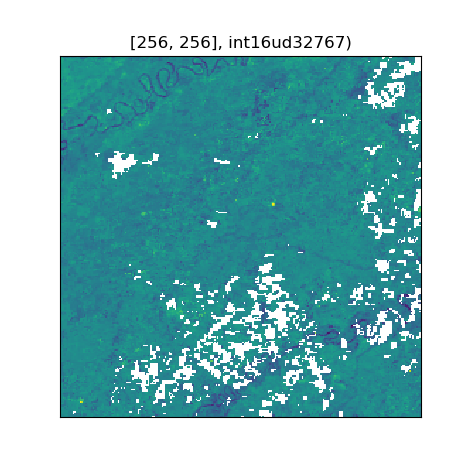
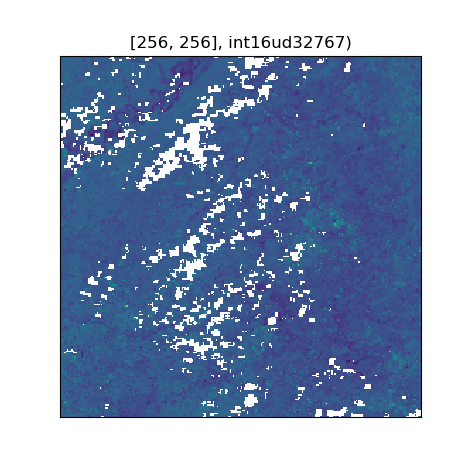
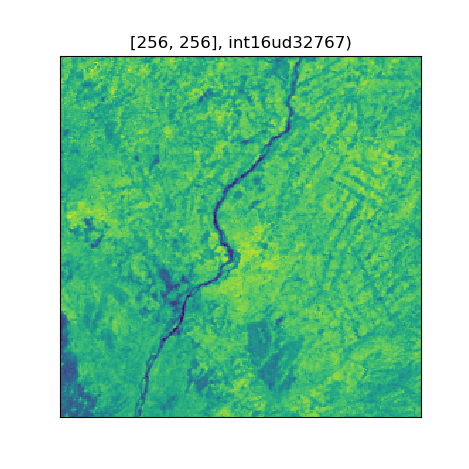

In [9]:
#Look at a sample
pandas_df = df.select(
    df.proj_raster_path,
    rf_extent(df.proj_raster).alias('extent'),
    rf_tile(df.proj_raster).alias('tile'),
).sample(0.05).toPandas()
pandas_df